In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn import metrics
sns.set('paper',
        'whitegrid',
        font_scale=1.25,
        palette='muted',#'colorblind',
        color_codes=True)
import os.path
from tqdm import tqdm

In [3]:
def load_results(base, dataset, experiment):
    extension = dict(
        pxgz_diff = "json",
        topic_distrib = "pkl",
        pred_benchmark = "jsonl",
        cvae_abow = "jsonl",
        cvae_lr = "jsonl"
    )[experiment]
        
    def read_files(fps):
        fns = [ fp.split("/")[-1] for fp in fps ]
        if extension == "json":
            data = []
            for fn, fp in zip(fns, fps):
                with open(fp) as fd:
                    data.append(json.load(fd))
                    data[-1]["filename"] = fn
            data = pd.DataFrame(data)
        elif extension == "jsonl":
            data = pd.concat([pd.read_json(fp, orient="records", lines=True) for fp in fps], ignore_index=True)
        elif extension == "pkl":
            data = {
                fn: pd.read_pickle(fp)
                for fn, fp in zip(fns, fps)
            }
        return data
    
    bpath = os.path.join(base, dataset, experiment)
    mglob = glob(bpath + "/*")
    models = [ _.split("/")[-1] for _ in mglob if os.path.isdir(_)]
    if not models:
        models = [bpath]
        
    results_dfs = []
    for m in models:
        mpath = os.path.join(bpath, m)
        mglob = mpath + "/*.{}".format(extension)
        rpaths = glob(mglob)
        mdf = read_files(rpaths)
        mdf['topic_model'] = m
        results_dfs.append(mdf)
    results = pd.concat(results_dfs, ignore_index=True)
    return results

## CVAE + LR

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


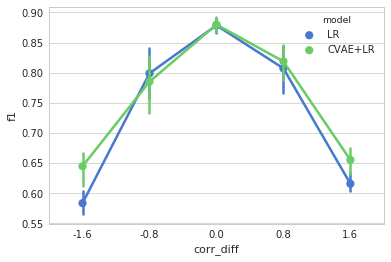

In [6]:
basepath = "/data/virgile/confound/adaptive/luigi/"
# dname = "yelp"
dname = "twitter_y=location_z=gender"
expmt = "cvae_lr"
r = load_results(basepath, dname, expmt)
r["corr_diff"] = r.corr_tr.round(1) - r.corr_te.round(1)
r["f1"] = r.apply(lambda row: metrics.f1_score(row.y_true, row.y_pred), axis=1)

sns.pointplot("corr_diff", "f1", hue="model", data=r)

## CVAE+ABOW

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


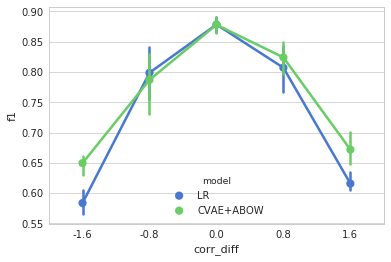

In [7]:
basepath = "/data/virgile/confound/adaptive/luigi/"
# dname = "yelp"
dname = "twitter_y=location_z=gender"
expmt = "cvae_abow"
r = load_results(basepath, dname, expmt)
r["corr_diff"] = r.corr_tr.round(1) - r.corr_te.round(1)
r["f1"] = r.apply(lambda row: metrics.f1_score(row.y_true, row.y_pred), axis=1)

sns.pointplot("corr_diff", "f1", hue="model", data=r)

# Hellinger Distance on p(x|z)

In [54]:
basepath = "/data/virgile/confound/adaptive/luigi/"
# dname = "yelp"
dname = "twitter_y=location_z=gender"
expmt = "pxgz_diff"
r = load_results(basepath, dname, expmt)

In [55]:
r['corr_diff'] = np.around(r.corr_tr, 1)  - np.around(r.corr_te, 1)
r['max_pxgz_delta'] = r.pxgz_delta.apply(lambda a: np.max([_ for _ in a if not np.isnan(_)]))

In [56]:
r.head()

,bias_te,bias_tr,corr_te,corr_tr,filename,pxgz_delta,topic_model,corr_diff,max_pxgz_delta
0,0.500000,0.500000,0.016002,-0.013945,trbias=0.500_tebias=0.500_size=1000_foldidx=1_...,"[nan, 0.0629920825964017, nan, 0.0530072974898...",TD_VAE,-0.0,0.115860
1,0.900000,0.901606,0.816104,0.786139,trbias=0.900_tebias=0.900_size=1000_foldidx=1_...,"[0.059002158140100354, 0.06993643284834754, 0....",TD_VAE,0.0,0.102548
2,0.500000,0.500000,-0.016131,0.015811,trbias=0.500_tebias=0.500_size=1000_foldidx=0_...,"[0.060236333721601254, 0.0901082409929734, nan...",TD_VAE,0.0,0.104779
3,0.099404,0.500000,-0.793999,-0.009881,trbias=0.500_tebias=0.100_size=1000_foldidx=2_...,"[0.046440911808757084, 0.09980122715266442, 0....",TD_VAE,0.8,0.108463
4,0.500000,0.900810,0.012097,0.782215,trbias=0.900_tebias=0.500_size=1000_foldidx=2_...,"[0.043268881257107754, 0.09664753582393315, 0....",TD_VAE,0.8,0.105371


/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


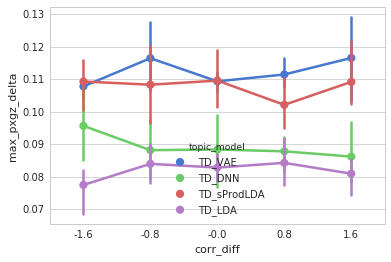

In [57]:
sns.pointplot(x="corr_diff", y="max_pxgz_delta", hue="topic_model", data=r)

# BA vs LR

In [8]:
expmt = "pred_benchmark"
r = load_results(basepath, dname, expmt)

In [9]:
r.head()

,bias_te,bias_tr,c_idx,c_val,corr_te,corr_tr,model,y_pred,y_prob,y_true,topic_model
0,0.099404,0.500000,NaN,NaN,-0.822216,0.015811,LR,"[0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...","[[0.5592341374, 0.4407658626], [0.9990556385, ...","[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...",TD_sProdLDA
1,0.099404,0.500000,NaN,NaN,-0.822216,0.015811,BA,"[0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...","[[0.5559110064, 0.44408899360000004], [0.99904...","[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...",TD_sProdLDA
2,0.099404,0.500000,96.0,0.094526,-0.822216,0.015811,BA_discovered,"[0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...","[[0.5559115833, 0.44408841670000004], [0.99903...","[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...",TD_sProdLDA
3,0.900000,0.901606,NaN,NaN,0.816104,0.786139,LR,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[[0.0391301339, 0.9608698661], [0.0469898043, ...","[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",TD_sProdLDA
4,0.900000,0.901606,NaN,NaN,0.816104,0.786139,BA,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[[0.15338533470000001, 0.8466146653000001], [0...","[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",TD_sProdLDA


In [10]:
def preprocess_results(df):
    df["f1"] = df.apply(lambda r: metrics.f1_score(r.y_true, r.y_pred), axis=1)
    df["corr_tr_round"] = np.round(df.corr_tr, decimals=1)
    df["corr_te_round"] = np.round(df.corr_te, decimals=1)
    df["corr_diff"] = df.apply(lambda r: r.corr_tr_round - r.corr_te_round, axis=1)
    df["model+topic_model"] = df.apply(lambda r: r.model if r.model != "BA_discovered" else "BA_Discovered + {}".format(r.topic_model), axis=1)

In [11]:
preprocess_results(r)

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


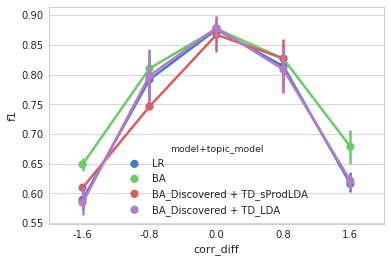

In [12]:
sns.pointplot(x="corr_diff", y="f1", hue="model+topic_model", data=r)